# Stable diffusion sandbox

## text to image pipeline

In [1]:
from diffusers import StableDiffusionPipeline
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler
from torchvision import transforms as tfms
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline 
device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
# pre-made pipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

## Load pre-trained models

In [4]:
# ad-hoc pipeline
def load_models(device):
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to(device)
    # vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
    vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to(device)
    unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(device)
    beta_start,beta_end = 0.00085,0.012
    scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)
    return tokenizer, text_encoder, vae, unet, scheduler

tokenizer, text_encoder, vae, unet, scheduler = load_models(device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.21.layer_norm1.weight', 'vision_model.encoder.layers.17.self_attn.v_proj.bias', 'vision_model.encoder.layers.12.mlp.fc2.weight', 'vision_model.encoder.layers.23.layer_norm2.weight', 'vision_model.encoder.layers.19.mlp.fc2.weight', 'vision_model.encoder.layers.9.layer_norm1.weight', 'vision_model.encoder.layers.4.self_attn.out_proj.bias', 'vision_model.encoder.layers.16.mlp.fc2.weight', 'vision_model.encoder.layers.22.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.self_attn.k_proj.weight', 'vision_model.encoder.layers.16.self_attn.k_proj.weight', 'vision_model.encoder.layers.0.layer_norm1.bias', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.10.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.mlp.fc2.bias', 'vision_model.encoder.layers.4.mlp.

## Input Params

In [5]:
prompt = ["a photograph of a mouse skiing"]
# torch.manual_seed(1234)
height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1


In [6]:
def encode_text(prompt, device='cuda'):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0].half()
    return text_embeddings

text_embeddings = encode_text(prompt)


In [31]:
def pil2latent(input_im, device='cuda'):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents2pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [32]:
img = Image.open('obama.jpg').resize((512, 512))
latents = pil2latent(img)
image = latents2pil(latents)


NameError: name 'torch_device' is not defined

In [ ]:
plt.imshow(image)

NameError: name 'plt' is not defined

In [ ]:
# max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))
latents = latents.to("cuda").half()
scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma

In [104]:
from tqdm.auto import tqdm

for i, t in enumerate(tqdm(scheduler.timesteps)):
    input = torch.cat([latents] * 2)
    input = scheduler.scale_model_input(input, t)

    # predict the noise residual
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample

with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample

  0%|          | 0/70 [00:00<?, ?it/s]

In [109]:
def make_img(image):
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image[0].detach().cpu().permute(1, 2, 0).numpy()
    image = (image * 255).round().astype("uint8")
    return image

image make_img(image)
plt.imshow(image)
    # Image.fromarray(image)

AttributeError: 'numpy.ndarray' object has no attribute 'clamp'

  0%|          | 0/71 [00:00<?, ?it/s]

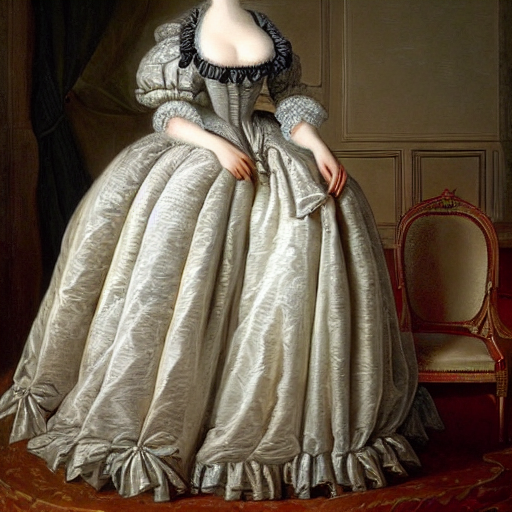

In [12]:
prompt = "Marie antoinette wearing a dress made of speakers"
pipe(prompt, num_inference_steps=70, guidance_scale=7.5).images[0]

## Image to image pipeline

In [34]:

from diffusers import StableDiffusionImg2ImgPipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

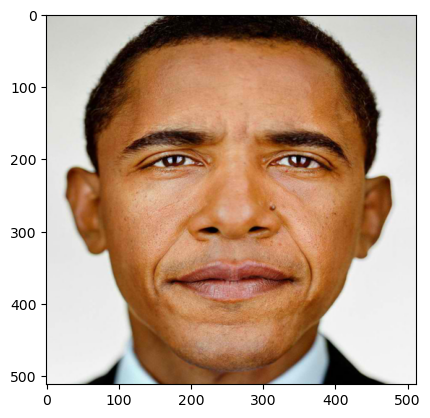

In [72]:
init_img = Image.open('obama.jpg').resize((512, 512))
plt.imshow(init_img)


In [3]:
prompt = "close-up portrait in the style of vermeer"
images = pipe(prompt=prompt, num_images_per_prompt=1, init_image=init_img, strength=1.0, num_inference_steps=50, guidance_scale=7.5).images[0]
plt.imshow(images)

NameError: name 'init_img' is not defined

In [50]:
??StableDiffusionImg2ImgPipeline

Init signature:
StableDiffusionImg2ImgPipeline(
    vae: diffusers.models.vae.AutoencoderKL,
    text_encoder: transformers.models.clip.modeling_clip.CLIPTextModel,
    tokenizer: transformers.models.clip.tokenization_clip.CLIPTokenizer,
    unet: diffusers.models.unet_2d_condition.UNet2DConditionModel,
    scheduler: Union[diffusers.schedulers.scheduling_ddim.DDIMScheduler, diffusers.schedulers.scheduling_pndm.PNDMScheduler, diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler],
    safety_checker: diffusers.pipelines.stable_diffusion.safety_checker.StableDiffusionSafetyChecker,
    feature_extractor: transformers.models.clip.feature_extraction_clip.CLIPFeatureExtractor,
)
Source:        
class StableDiffusionImg2ImgPipeline(DiffusionPipeline):
    r"""
    Pipeline for text-guided image to image generation using Stable Diffusion.

    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods the
    library implements for 